In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from tqdm import tqdm

from numpy import warnings
warnings.filterwarnings('ignore')

from numba import jit

# Part 1, Theory
## Question 1

In [2]:
q1_input_signal = [4, 1, 5, 1, 4]

def up_sample(original_signal, factor):
    """
    (1) pad the original signal, with (factor - 1) zero in between each pair
    in the original signal.
    (2) performs convolution with appropriate size, to get the the linear
    interpolated up-sampling result
    """
    padded_signal = [] # start with empty, add zeros in between
    for element in original_signal:
        padded_signal.append(element)
        padded_signal.extend([0] * (factor - 1))
    # discard the last bunch of zeros
    padded_signal = np.array(padded_signal[ : -(factor - 1)])

    conv_filter = np.array([i / factor for i in list(range(0, factor)) + list(range(factor, -1, -1))])
    return np.convolve(padded_signal, conv_filter)
    
q1_upsampled = up_sample(q1_input_signal, 4)

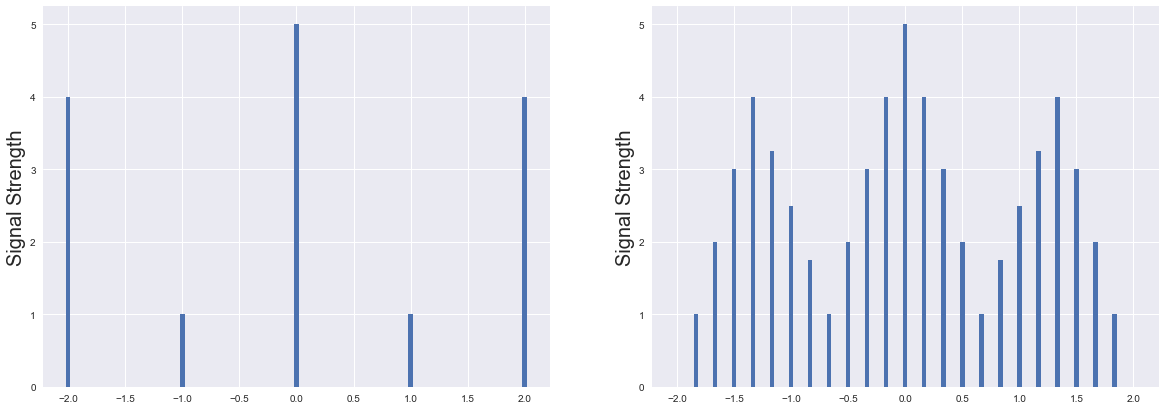

In [3]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
ax1.set_ylabel('Signal Strength', fontsize=20)
ax1.bar(np.linspace(-2, 2, 5), q1_input_signal, width=0.04)
ax2.set_ylabel('Signal Strength', fontsize=20)
ax2.bar(np.linspace(-2, 2, len(q1_upsampled)), q1_upsampled, width=0.04)

fig.savefig("./figs/q1_upsample.pdf", bbox_inches = 'tight', pad_inches = 0)

# Part 2, Image Resizing with Seam Carving

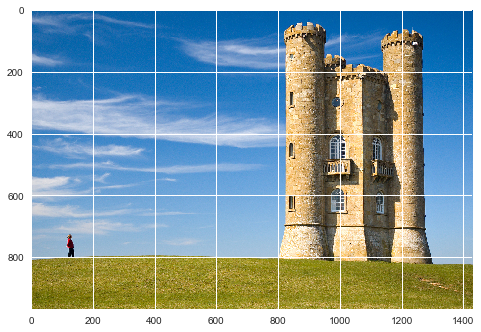

In [4]:
img = cv2.cvtColor(cv2.imread("./ex1.jpg"), cv2.COLOR_BGR2RGB)
grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img)

In [5]:
@jit
def calc_grad_magnitude(
    image,
    gx = np.array([
        [-1, -2, -1], [0, 0, 0], [1, 2, 1]
    ]),
    gy = np.array([
        [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]
    ])):
    """
    calculate gradient magnitudes, using gx and gy as finite difference 
    gradeint convolution operators. Default Sobel Filters.
    
    If image is 3d tensor (three color channels, then apply channel-wise)
    """
    # later figured out we should still do grey scale...
    if image.ndim == 3:
        grad_all_channels = np.zeros_like(image)
        for i in range(0, image.shape[-1]):
            sobel_x = convolve2d(image[:, :, i], gx, mode="same")
            sobel_y = convolve2d(image[:, :, i], gy, mode="same")
            grad_all_channels[:, :, i] = np.sqrt(
                sobel_x ** 2 + sobel_y ** 2
            )
        return grad_all_channels
    elif image.ndim == 2:
        return np.sqrt(convolve2d(image, gx) ** 2 + convolve2d(image, gy) ** 2)
    pass

In [6]:
grad = calc_grad_magnitude(grey_img)

In [13]:
@jit
def get_energy_map(grad):
    """
    bottom up DP implementation, getting the energy map from gradient
    """
    R, C = grad.shape
    energy_map = np.zeros_like(grad)
    # can also get this from sequencial finding min along a path, but this is easier
    track = np.zeros_like(grad, dtype=np.int)
    # vectorize assign bottom row
    energy_map[-1, :] = grad[-1, :]
    # all rows from second bottom row and up
    for r in range(R - 2, -1, -1):
        # each row left to right
        for c in range(C):
            if c == 0: #if left edge
                energy_map[r, c] = np.min(energy_map[r + 1, c: c + 2]) + grad[r, c]
                track[r, c] = np.argmin(energy_map[r + 1, c: c + 2]) + c - 1
            elif c == C - 1: # elif right edge
                energy_map[r, c] = np.min(energy_map[r + 1, c - 1: c + 1]) + grad[r, c]
                track[r, c] = np.argmin(energy_map[r + 1, c - 1: c + 1]) + c - 1
            else: # else center
                energy_map[r, c] = np.min(energy_map[r + 1, c - 1: c + 2]) + grad[r, c]
                track[r, c] = np.argmin(energy_map[r + 1, c - 1: c + 2]) + c - 1

    return energy_map, track

In [14]:
emap, track = get_energy_map(grad)
plt.imshow(emap)

LoweringError: Failed in object mode pipeline (step: object mode frontend)
Failed in object mode pipeline (step: object mode backend)
[1m[1m(<class 'numba.ir.StaticSetItem'>, energy_map[(-1, slice(None, None, None))] = $0.24)
[1m
File "<ipython-input-13-22a6b9971569>", line 11:[0m
[1mdef get_energy_map(grad):
    <source elided>
    # vectorize assign bottom row
[1m    energy_map[-1, :] = grad[-1, :]
[0m    [1m^[0m[0m
[0m
[0m[1m[1] During: lowering "energy_map[(-1, slice(None, None, None))] = $0.24" at <ipython-input-13-22a6b9971569> (11)[0m
-------------------------------------------------------------------------------
This should not have happened, a problem has occurred in Numba's internals.

Please report the error message and traceback, along with a minimal reproducer
at: https://github.com/numba/numba/issues/new

If more help is needed please feel free to speak to the Numba core developers
directly at: https://gitter.im/numba/numba

Thanks in advance for your help in improving Numba!



In [ ]:
@jit
def seam_carve(image, expected_size):
    R, C, channel = image.shape
    assert channel == 3, "not rgb image"
    grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    exp_R, exp_C = expected_size
    assert R >= exp_R and C >= exp_C, "cannot seam carve into larger size"
    
    # lets first focus on seam carving revoming columns only
    assert R == exp_R, "un supporetd change of Rows"
    
    for carv_idx in tqdm(range(C - exp_C)):
        mask = np.ones_like(grey_image, dtype=np.bool)
        energy_map, track = get_energy_map(grey_image)
        min_col_idx = np.argmin(energy_map[0, :])
        # the first to remove will be at (row=0, col=top_min_col_idx)
        for r in range(R):
            mask[r, min_col_idx] = False
            min_col_idx = track[r, min_col_idx]
            
        mask = np.stack([mask] * 3, axis=2)
        # new image with one less col
        image = image[mask].reshape((R, C - carv_idx - 1, 3))
        # since new image (1 less col), new grey image
        grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

In [ ]:
castle_carved = seam_carve(img, (968, 957))
plt.imshow(castle_carved)